In [1]:
pip install aif360

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from clearbox_engine import Dataset, Preprocessor, TabularEngine, LabeledSynthesizer
import matplotlib.pyplot as plt
import copy

# Ensure reproducibility
np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
LICENSE_KEY = "licensekeyoverride2023@"
file_path = "https://raw.githubusercontent.com/gillus/Corso_MLOps/refs/heads/main/data"

train_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_training.csv"),
    target_column="income",
    regression=False
)

test_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_test.csv"),
    column_types=train_dataset.column_types,
    target_column=train_dataset.target_column,
    regression=train_dataset.regression
)


In [4]:
# Function to filter dataset based on the mask
def filter_dataset_for_positive_women(dataset):
    features_array = dataset.get_x()
    labels_array = dataset.get_y()
    features_df = pd.DataFrame(features_array, columns=dataset.x_columns())
    mask = (features_df["sex"] == "Female") & (labels_array == ">50K")
    filtered_features = features_df.loc[mask]
    filtered_labels = pd.Series(labels_array).loc[mask].reset_index(drop=True)
    combined_df = pd.concat([filtered_features.reset_index(drop=True), filtered_labels.rename("income")], axis=1)
    return Dataset(
        data=combined_df,
        column_types=dataset.column_types,
        target_column="income",
        regression=dataset.regression
    )

In [5]:
# Apply filtering to both train and test datasets
train_filtered_dataset = filter_dataset_for_positive_women(train_dataset)
test_filtered_dataset = filter_dataset_for_positive_women(test_dataset) 


In [6]:
# This part of code is done in order to find out which categories are mismatched after one hot incoding when they are preprocessed by the synthesizer

#  Preprocess the train and test datasets to inspect the mismatched categories
preprocessor_train = Preprocessor(train_filtered_dataset)
preprocessor_test = Preprocessor(test_filtered_dataset)

# Extract the categorical transformer
train_categorical_transformer = None
test_categorical_transformer = None

for transformer in preprocessor_train.transformer.transformers_:
    if transformer[0] == "categorical_transformer":
        train_categorical_transformer = transformer[1]

for transformer in preprocessor_test.transformer.transformers_:
    if transformer[0] == "categorical_transformer":
        test_categorical_transformer = transformer[1]


# Access and compare categories
train_categories = train_categorical_transformer.encoder.categories_
test_categories = test_categorical_transformer.encoder.categories_

# Identify mismatched categories
categorical_columns = preprocessor_train.categorical_features
mismatched_categories = {}

for i, col in enumerate(categorical_columns):
    train_cats = set(train_categories[i])
    test_cats = set(test_categories[i])
    extra_in_test = test_cats - train_cats
    extra_in_train = train_cats - test_cats

    if extra_in_test or extra_in_train:
        mismatched_categories[col] = {
            'extra_in_test': extra_in_test,
            'extra_in_train': extra_in_train
        }

# Adjust the data to align categories
train_features = pd.DataFrame(train_filtered_dataset.get_x(), columns=train_filtered_dataset.x_columns())
test_features = pd.DataFrame(test_filtered_dataset.get_x(), columns=test_filtered_dataset.x_columns())

for col, values in mismatched_categories.items():
    # Remove rows with extra values in test
    if values['extra_in_test']:
        print(f"Removing rows from test where {col} has values: {values['extra_in_test']}")
        test_features = test_features[~test_features[col].isin(values['extra_in_test'])]
    # Remove rows with extra values in train
    if values['extra_in_train']:
        print(f"Removing rows from train where {col} has values: {values['extra_in_train']}")
        train_features = train_features[~train_features[col].isin(values['extra_in_train'])]

# Reset indices
train_features = train_features.reset_index(drop=True)
test_features = test_features.reset_index(drop=True)

# Add the target column
# Ensure the 'income' column is present in both datasets
train_features['income'] = train_filtered_dataset.get_y()
test_features['income'] = test_filtered_dataset.get_y()

# Verify columns
print("Updated train features columns:", train_features.columns)
print("Updated test features columns:", test_features.columns)

# Replace datasets with target column
train_filtered_dataset_fixed = Dataset(
    data=train_features,
    column_types=train_filtered_dataset.column_types,
    target_column='income',  # Set the target column name
    regression=train_filtered_dataset.regression
)

test_filtered_dataset_fixed = Dataset(
    data=test_features,
    column_types=test_filtered_dataset.column_types,
    target_column='income',  # Set the target column name
    regression=test_filtered_dataset.regression
)

# Verify alignment 
preprocessor_train_fixed = Preprocessor(train_filtered_dataset_fixed)
preprocessor_test_fixed = Preprocessor(test_filtered_dataset_fixed)

X_train_transformed = preprocessor_train_fixed.transform(train_filtered_dataset_fixed.get_x())
X_test_transformed = preprocessor_test_fixed.transform(test_filtered_dataset_fixed.get_x())

print("Final Train Transformed Shape:", X_train_transformed.shape)
print("Final Test Transformed Shape:", X_test_transformed.shape)


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(


Removing rows from test where work_class has values: {'*'}
Removing rows from test where relationship has values: {'Other-relative'}
Removing rows from train where relationship has values: {'*'}
Removing rows from test where native_country has values: {'SE-Asia'}
Updated train features columns: Index(['age', 'work_class', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'income'],
      dtype='object')
Updated test features columns: Index(['age', 'work_class', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'income'],
      dtype='object')
Final Train Transformed Shape: (1112, 39)
Final Test Transformed Shape: (356, 39)


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (356). n_quantiles is set to n_samples.
  warnings.warn(


In [9]:
# Preprocess train dataset
preprocessor = Preprocessor(train_filtered_dataset_fixed)
X_train_raw = train_filtered_dataset_fixed.get_x()
X_train_transformed = preprocessor.transform(X_train_raw)
Y_train = train_filtered_dataset_fixed.get_one_hot_encoded_y()


In [10]:
# Train TabularEngine
engine = TabularEngine(
    license_key=LICENSE_KEY,
    layers_size=[50],
    x_shape=X_train_transformed[0].shape,
    y_shape=Y_train[0].shape,
    ordinal_feature_sizes=preprocessor.get_features_sizes()[0],
    categorical_feature_sizes=preprocessor.get_features_sizes()[1],
)
engine.fit(X_train_transformed, y_train_ds=Y_train, epochs=5, learning_rate=0.001)

2025-01-17 08:26:01.978 | INFO     | __main__:<module>:2 - I'm the Sept 2024 engine!


Clearbox AI Engine: your license is valid.


Engine fitting in progress: 100%|██████████| 5/5 [00:13<00:00,  2.72s/epoch, Train loss:=4196.27]


In [11]:
# Generate synthetic train and test datasets
train_synthesizer = LabeledSynthesizer(train_filtered_dataset_fixed, engine)
test_synthesizer = LabeledSynthesizer(test_filtered_dataset_fixed, engine) 

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (356). n_quantiles is set to n_samples.
  warnings.warn(


In [12]:
def generate_synthetic_data(synthesizer, num_datasets=3):
    synthetic_dfs = [synthesizer.generate(has_header=True) for _ in range(num_datasets)]
    combined_synthetic_df = pd.concat(synthetic_dfs, ignore_index=True)
    return combined_synthetic_df

In [13]:

train_synthetic_combined_df = generate_synthetic_data(train_synthesizer)
test_synthetic_combined_df = generate_synthetic_data(test_synthesizer)

print("Synthetic data generated for train and test datasets!")

 Synthetic data generated for train and test datasets!


In [14]:
#  Combine Original and Synthetic Data

# Convert original train and test sets to DataFrames
train_original_df = pd.DataFrame(train_dataset.get_x(), columns=train_dataset.x_columns())
train_original_df["income"] = train_dataset.get_y()

test_original_df = pd.DataFrame(test_dataset.get_x(), columns=test_dataset.x_columns())
test_original_df["income"] = test_dataset.get_y()


# Combine original and synthetic datasets
train_combined_df = pd.concat([train_original_df, train_synthetic_combined_df], ignore_index=True)
test_combined_df = pd.concat([test_original_df, test_synthetic_combined_df], ignore_index=True)




In [15]:
# One-Hot Encoding and Column Alignment

categorical_columns = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "native_country"]

# One-hot encode combined datasets
train_combined_df = pd.get_dummies(train_combined_df, columns=categorical_columns)
test_combined_df = pd.get_dummies(test_combined_df, columns=categorical_columns)

# Align test_combined_df columns with train_combined_df
test_combined_df = test_combined_df.reindex(columns=train_combined_df.columns, fill_value=0)

# Map 'sex' and 'income' to numerical values
train_combined_df["sex"] = train_combined_df["sex"].map({"Female": 0.0, "Male": 1.0})
train_combined_df["income"] = train_combined_df["income"].map({">50K": 1.0, "<=50K": 0.0})

test_combined_df["sex"] = test_combined_df["sex"].map({"Female": 0.0, "Male": 1.0})
test_combined_df["income"] = test_combined_df["income"].map({">50K": 1.0, "<=50K": 0.0})

# One-hot encode original train and test datasets
train_original_df = pd.get_dummies(train_original_df, columns=categorical_columns)
test_original_df = pd.get_dummies(test_original_df, columns=categorical_columns)

# Align columns for original train and test datasets
test_original_df = test_original_df.reindex(columns=train_original_df.columns, fill_value=0)
train_original_df = train_original_df.reindex(columns=test_original_df.columns, fill_value=0)

# Map 'sex' and 'income' to numerical values in original datasets
train_original_df["sex"] = train_original_df["sex"].map({"Female": 0.0, "Male": 1.0})
train_original_df["income"] = train_original_df["income"].map({">50K": 1.0, "<=50K": 0.0})

test_original_df["sex"] = test_original_df["sex"].map({"Female": 0.0, "Male": 1.0})
test_original_df["income"] = test_original_df["income"].map({">50K": 1.0, "<=50K": 0.0})

# Convert values to float
train_original_df = train_original_df.astype(float)
test_original_df = test_original_df.astype(float)

print("One-hot encoding and column alignment done!")


One-hot encoding and column alignment done!


In [16]:
# Convert to BinaryLabelDataset
train_combined_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=train_combined_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

test_combined_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=test_combined_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

train_original_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=train_original_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

test_original_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=test_original_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)


print("BinaryLabelDataset conversion successful!")


BinaryLabelDataset conversion successful!


In [17]:
# Load the validation dataset
validation_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_validation.csv"),
    column_types=train_dataset.column_types,
    target_column=train_dataset.target_column,
    regression=train_dataset.regression
)

# Convert validation dataset to a DataFrame
val_original_df = pd.DataFrame(validation_dataset.get_x(), columns=validation_dataset.x_columns())
val_original_df["income"] = validation_dataset.get_y()

# One-hot encode categorical variables in validation set
val_original_df = pd.get_dummies(val_original_df, columns=categorical_columns)

# Align validation set columns to match the train_original_df
val_original_df = val_original_df.reindex(columns=train_original_df.columns, fill_value=0)

# Map 'sex' and 'income' to numerical values in validation dataset
val_original_df["sex"] = val_original_df["sex"].map({"Female": 0.0, "Male": 1.0})
val_original_df["income"] = val_original_df["income"].map({">50K": 1.0, "<=50K": 0.0})

# Ensure all values are numerical
val_original_df = val_original_df.astype(float)

# Convert to BinaryLabelDataset
val_original_dataset = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=val_original_df,
    label_names=["income"],
    protected_attribute_names=["sex"]
)

print("Validation dataset prepared and converted to BinaryLabelDataset successfully!")

Validation dataset prepared and converted to BinaryLabelDataset successfully!


In [18]:
train = train_original_dataset
train_transf = train_combined_dataset
test = test_original_dataset
test_transf = test_combined_dataset
val = val_original_dataset

In [19]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [71]:
# Evaluate fairness metrics before applying bias mitigation
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.2002
  Disparate Impact: 0.3622

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1967
  Disparate Impact: 0.3654


In [72]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")


Train Dataset (After Transformation):
  Statistical Parity Difference: 0.0252
  Disparate Impact: 1.0804

Test Dataset (After Transformation):
  Statistical Parity Difference: 0.0205
  Disparate Impact: 1.0660


In [73]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)

In [74]:
classifier = LogisticRegression(random_state=1, solver='liblinear', max_iter=1000)

In [75]:

# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1]

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.21000000000000002
Best Balanced Accuracy (validation): 0.817569915996163


In [76]:
# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.8158929171377768
Statistical Parity Difference (test): -0.3658105610893654
Disparate Impact (test): 0.2957369481123719
Average Odds Difference (test): -0.22553133790350702
Equal Opportunity Difference (test): -0.18605974504097822
Theil Index (test): 0.07824140256940872


In [77]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

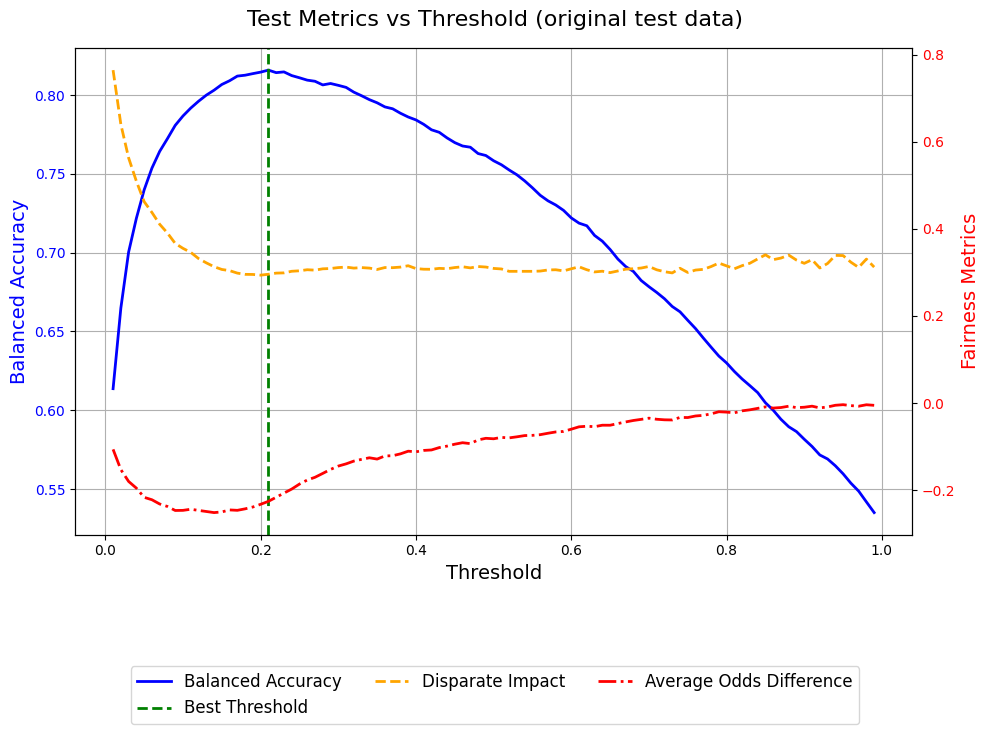

In [78]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()


In [61]:
classifier.fit(train_transf.features, train_transf.labels.ravel())
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(test_transf.features)[:, 1]
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test_transf)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test_transf, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.80433373313009
Statistical Parity Difference (test): -0.05062097913949437
Disparate Impact (test): 0.9001682605246651
Average Odds Difference (test): -0.0396325114069669
Equal Opportunity Difference (test): 0.026374530191324075
Theil Index (test): 0.0810873294222261


In [85]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    # Generate predictions based on the threshold
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test_transf)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    # Compute fairness metrics using the ClassificationMetric class
    test_transf_metric = ClassificationMetric(test_transf, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

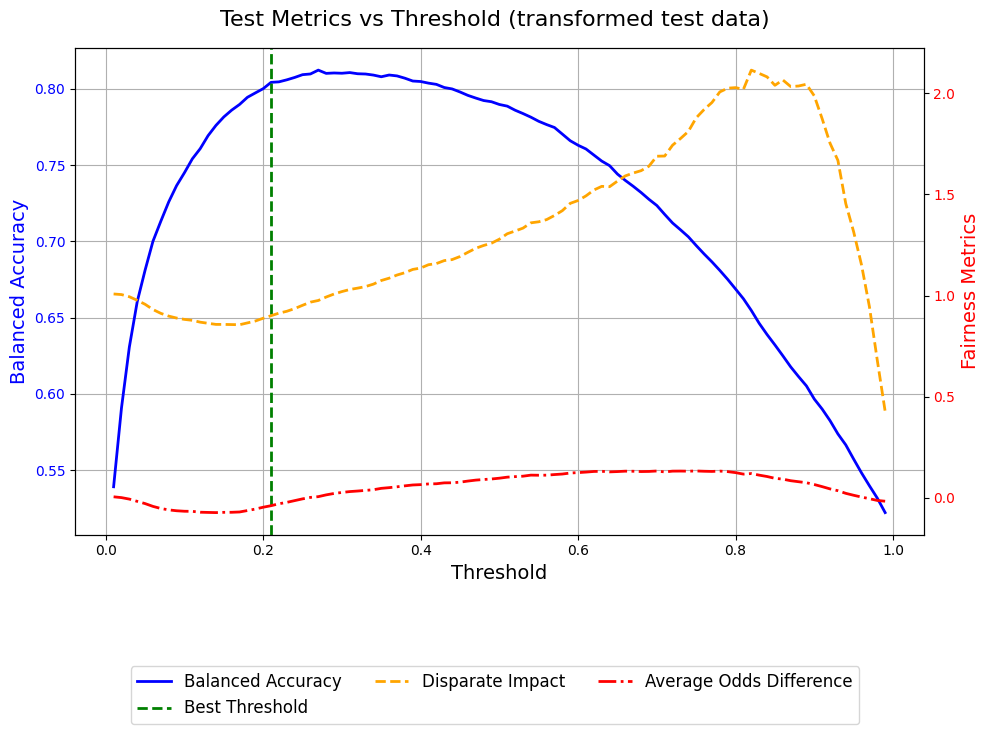

In [86]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

#ax2.set_ylim(-0.05, 0.07) 
ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [87]:
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)
# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)

'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.200159
1,Train,After Transformation,Statistical Parity Difference,0.025239
2,Test,Before Transformation,Statistical Parity Difference,-0.196652
3,Test,After Transformation,Statistical Parity Difference,0.020465
4,Train,Before Transformation,Disparate Impact,0.362220
5,Train,After Transformation,Disparate Impact,1.080421
6,Test,Before Transformation,Disparate Impact,0.365410
7,Test,After Transformation,Disparate Impact,1.066040


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.21000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.81757


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.815893
1,Test (Transformed),After Threshold,Balanced Accuracy,0.804334
2,Test (Original),After Threshold,Statistical Parity Difference,-0.365811
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.050621
4,Test (Original),After Threshold,Disparate Impact,0.295737
5,Test (Transformed),After Threshold,Disparate Impact,0.900168
6,Test (Original),After Threshold,Average Odds Difference,-0.225531
7,Test (Transformed),After Threshold,Average Odds Difference,-0.039633
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.186060
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.026375
